# NSBI diagnostics

In the previous chapter, we've trained CARL models that approximate the density ratio between two hypotheses of an event:

$$
 \hat{r}(x ; H_1, H_2) \sim r ( x ; H_1, H_2) \equiv \frac{p(x | H_1)}{p(x | H_2)}
$$

The validity of our NSBI results, of course, depends on close this approixmation, $~$, holds. We will perform two diagnostics to gauge how well our estimates are performing.

In [9]:
import numpy as np
import pandas as pd
import matplotlib, matplotlib.pyplot as plt
import vector
import hist

import torch
torch.set_float32_matmul_precision('medium')
from torch.utils.data import TensorDataset, DataLoader
import lightning as L

from physics.analysis import zz4l, zz2l2v
from datasets.balanced import BalancedDataset
from nsbi import carl

## 0. Load the training/validation data, scaler, and model checkpoint

First, we'll load everything we need. Note that if you set the same seed for the two models come into play, you only need to load denominator hypothesis datasets once; otherwise you will need the denominator datasets corresponding to each model separately.

In [10]:
run_dir = 'run/h4l'

(events_sig_train, events_sig_val), (events_bkg_train, events_bkg_val) = carl.utils.load_data(run_dir, 'sig_over_bkg')
(events_sbi_train, events_sbi_val), _ = carl.utils.load_data(run_dir, 'sbi_over_bkg')  # same seed!

scaler_sig_over_bkg, model_sig_over_bkg = carl.utils.load_results(run_dir, 'sig_over_bkg')
scaler_sbi_over_bkg, model_sbi_over_bkg = carl.utils.load_results(run_dir, 'sbi_over_bkg')

features_4l = ['l1_pt', 'l1_eta', 'l1_phi', 'l1_energy', 'l2_pt', 'l2_eta', 'l2_phi', 'l2_energy', 'l3_pt', 'l3_eta', 'l3_phi', 'l3_energy', 'l4_pt', 'l4_eta', 'l4_phi', 'l4_energy']


## 1. Reweighting

An intuitive expectation of a DRE is that it should provide a correspondingly accurate reweighting of an event between hypotheses:

$$
 \hat{p}(x | H_1) = p(x| H_2) \times \hat{r}(x ; H_1, H_2) \Rightarrow \hat{w}_{H_1}(x) = w_{H_2}(x) \times r( x ; H_1, H_2) / N
$$

where $N$ is an arbitrary normalization factor (remember: we are performing a *density* ratio estimate!). In order to perform this check for one estimate, you must:

1. Scale the features of the denominator hypothesis events using the scaler from training.
2. Run the model over the scaled features.
3. Perform the likelihood trick over the output.

In [11]:
# IMPLEMENT ME
events_num_train, events_num_val = events_sbi_train, events_sbi_val 
scaler = scaler_sbi_over_bkg
model = model_sbi_over_bkg
events_denom_train, events_denom_val = events_bkg_train, events_bkg_val

X_denom_train, X_denom_val = scaler.transform(events_denom_train.kinematics[features_4l].to_numpy()), scaler.transform(events_denom_val.kinematics[features_4l].to_numpy())
dl_denom_train, dl_denom_val = DataLoader(TensorDataset(torch.tensor(X_denom_train, dtype=torch.float32)), batch_size=1024), DataLoader(TensorDataset(torch.tensor(X_denom_val, dtype=torch.float32)), batch_size=1024) 

trainer = L.Trainer(accelerator='gpu', devices=1)
s_num_vs_denom = torch.cat(trainer.predict(model, dl_denom_train))
r_num_over_denom = s_num_vs_denom / (1 - s_num_vs_denom)

Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: ModelCheckpoint
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]
/afs/ipp-garching.mpg.de/home/t/taepa/.local/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=127` in the `DataLoader` to improve performance.


Predicting: |                                                                                                 …

# 1. (b) Compare numerator vs. denominator-reweighted distributions

1. Multiply the DRE onto the denominator hypothesis event weights.
2. Compare distributions of an observable, e.g. $m_{4\ell}$, obtained using (1) numerator hypothesis events & weights, and (2) denominator hypothesis events & reweights.

[StairsArtists(stairs=<matplotlib.patches.StepPatch object at 0x7f8287f6a440>, errorbar=None, legend_artist=None)]

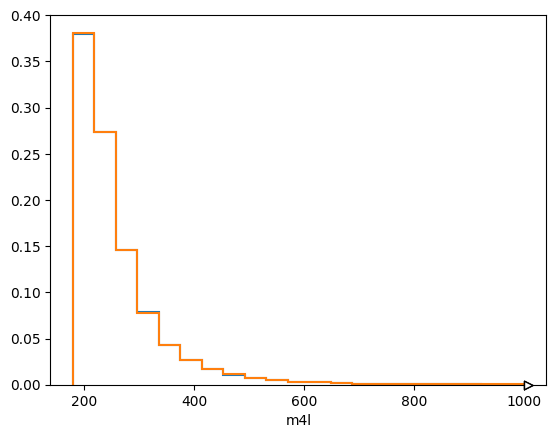

In [12]:
m4l_axis = hist.axis.Regular(21, 180, 1000, label = 'm4l')
h_m4l_num = hist.Hist(m4l_axis)
h_m4l_num_from_denom = hist.Hist(m4l_axis)

def calculate_m4l(kinematics):
    p_l1 = vector.array({'pt': kinematics['l1_pt'], 'eta': kinematics['l1_eta'], 'phi': kinematics['l1_phi'], 'energy': kinematics['l1_energy']})
    p_l2 = vector.array({'pt': kinematics['l2_pt'], 'eta': kinematics['l2_eta'], 'phi': kinematics['l2_phi'], 'energy': kinematics['l2_energy']})
    p_l3 = vector.array({'pt': kinematics['l3_pt'], 'eta': kinematics['l3_eta'], 'phi': kinematics['l3_phi'], 'energy': kinematics['l3_energy']})
    p_l4 = vector.array({'pt': kinematics['l4_pt'], 'eta': kinematics['l4_eta'], 'phi': kinematics['l4_phi'], 'energy': kinematics['l4_energy']})
    return (p_l1 + p_l2 + p_l3 + p_l4).mass


# IMPLEMENT ME
# NOTE: What should you do about the arbitrary normalization factor, N, from above?
w_num = torch.tensor(events_num_train.weights)
w_num_from_denom = torch.tensor(events_denom_train.weights) * r_num_over_denom
w_num /= torch.sum(w_num)
w_num_from_denom /= torch.sum(w_num_from_denom)

h_m4l_num.fill( calculate_m4l(events_num_train.kinematics), weight=w_num)
h_m4l_num_from_denom.fill( calculate_m4l(events_denom_train.kinematics), weight=w_num_from_denom)

h_m4l_num.plot()
h_m4l_num_from_denom.plot()

As performed in Chapter 1, you are encouraged to check in more detail via ratio plots. Qualitatively, are the histograms "compatible"?

## 2. Calibration curve

A more direct and systematic way to check is to obtain what is referred to as the _calibration_ curve of the DRE.
Directly working with the predictions pre-likelihood ratio trick, the outputs should approximate

$$
s (x ; H_1, H_2) = \frac{p_{H_1}(x)}{p_{H_1}(x) + p_{H_2}(x)}
$$

as an unbiased function of $x$. We can check if this is satisfied by performing the following:

1. Bin events sampled from the numerator & denominator hypotheses according the classifier estimate, $\hat s$. 
2. In each bin, count the occurrence of events originating from the numerator & denominator hypothesis.
    - IMPORTANT: You must count using the balanced weights of each hypothesis!
3. Compute an "MC" estimate of the decision function in each bin, $s = \frac{N(y=1)}{N(y=0) + N(y=1)}$.

### 2.(a) Run the model over the numerator & denominator hypothesis datasets


We will make use of the pre-available `BalancedDataset` implementation (which was also used in the training) to consistently perform the $x$-scaling, event weight balancing, and $y = 0,1$ labeling of the numerator & denominator hypotheses.


In [13]:
ds_balanced = BalancedDataset(events_num_train, events_denom_train, features=features_4l, scaler=scaler)
dl = torch.utils.data.DataLoader(torch.tensor(ds_balanced.X, dtype=torch.float32), batch_size=1024)
s_num_vs_denom = torch.cat(trainer.predict(model, dl)).detach().numpy()

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]
/afs/ipp-garching.mpg.de/home/t/taepa/.local/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=127` in the `DataLoader` to improve performance.


Predicting: |                                                                                                 …

### 2.(b) Define the $\hat{s}$ binning

In [14]:
s_bins = np.linspace(0.0, 1.0, 41)
s_centers = (s_bins[:-1] + s_bins[1:])/2
s_nbins = len(s_bins) -1
s_widths = (s_bins[1:] - s_bins[:-1])/2
s_axis = hist.axis.Regular(40,0,1.0)

### 2.(c) Count the events from each hypothesis in each $\hat{s}$ bin

In [15]:
h_num, h_denom = hist.Hist(s_axis, storage=hist.storage.Weight()), hist.Hist(s_axis, storage=hist.storage.Weight())

# IMPLEMENT ME
h_num.fill(s_num_vs_denom[ds_balanced.s==1], weight = ds_balanced.w[ds_balanced.s==1])
h_denom.fill(s_num_vs_denom[ds_balanced.s==0], weight = ds_balanced.w[ds_balanced.s==0])
# ---

N = h_num.values()
D = h_denom.values()
VN = h_num.variances()
VD = h_denom.variances()
s_mc_val = N / (N + D)
s_mc_err = np.sqrt((D / np.square(N + D))**2 * VN + (N / np.square(N + D))**2 * VD)

/tmp/ipykernel_3188178/2869549778.py:12: RuntimeWarning: invalid value encountered in divide
  s_mc_val = N / (N + D)
/tmp/ipykernel_3188178/2869549778.py:13: RuntimeWarning: invalid value encountered in divide
  s_mc_err = np.sqrt((D / np.square(N + D))**2 * VN + (N / np.square(N + D))**2 * VD)


### 2.(d) Obtain the calibration curve

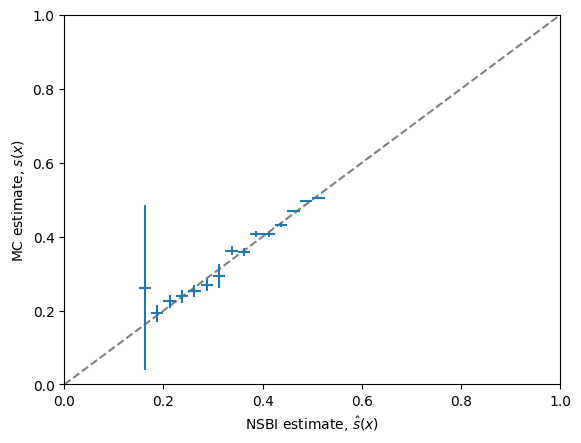

In [16]:
# IMPLEMENT ME
plt.plot([0,1], [0,1], marker='none', linestyle='--', color='grey')
plt.xlabel("NSBI estimate, $\hat{s}(x)$")
plt.ylabel("MC estimate, $s(x)$")
plt.xlim(0,1)
plt.ylim(0,1)
plt.errorbar(s_centers, s_mc_val, xerr=s_widths, yerr=s_mc_err, linestyle='none')
plt.show()

How does the calibration curve look? Is it close to a diagonal line?

**Task: Obtain the calibration curve diagnostic over valdation data, for the $p_{\rm SBI}(x) / (p_{\rm SBI}(x) + p_{\rm B} (x))$ estimate.**

Extra: The calibration curve is useful in the sense that now we can quantitavely evaluate how (in)accurate our network predictions are as a function of its input variables. Mathematically speaking, as long as the curve obtained above is _monotonic_, one can in principle derive a calibration function, $C(x)$,

$$
C(x) \times \left< \hat{s}(x) \right> = \left< s(x) \right>
$$,

that gives an un-biased (but not without variance) estimate of the probability ratio. For the next chapter we will assume that this calibration is perfect; the next tutorial on ensembling will allow us to get a handle on additional uncertainties that should be accounted for due to statistical sources including this model mis-specification.